In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModel
from transformers import ViTImageProcessor, ViTModel
from sklearn.decomposition import PCA
from tqdm import tqdm
import os
import requests
from PIL import Image
import io

/Users/mglambert/Documents/PhD/Courses/RecSys/RecSysProject/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mglambert/Documents/PhD/Courses/RecSys/RecSysProject/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_games = pd.read_csv('../data/df_games_train2.csv')
df_games.head()

,BGGId,Name,Description,YearPublished,GameWeight,AvgRating,BayesAvgRating,StdDev,MinPlayers,MaxPlayers,...,Rank:childrensgames,Cat:Thematic,Cat:Strategy,Cat:War,Cat:Family,Cat:CGS,Cat:Abstract,Cat:Party,Cat:Childrens,mask
0,88,Torres,torre abstract game resource management tactic...,1999,2.8656,7.10972,6.82406,1.27896,2,4,...,21926,0,1,0,0,0,1,0,0,True
1,91,Paths of Glory,gmt game websitethey call great war year titan...,1999,3.8421,8.05888,7.33726,1.64059,2,2,...,21926,0,0,1,0,0,0,0,0,True
2,150,PitchCar,game entry refer nearly identical game compati...,1995,1.1263,7.26579,6.99936,1.34552,2,8,...,21926,0,0,0,1,0,0,1,0,True
3,171,Chess,chess twoplayer abstract strategy board game r...,1475,3.6886,7.15112,6.96557,1.83887,2,2,...,21926,0,0,0,0,0,1,0,0,True
4,188,Go,appearance player take turn lay stone time sma...,-2200,3.9420,7.63525,7.31794,1.91275,2,2,...,21926,0,0,0,0,0,1,0,0,True


In [3]:
df_games.loc[0, 'Description']

'torre abstract game resource management tactical pawn movement   player attempt build castle position knight score point turn   player limited supply knight action card allow special action take   efficient use piece card thoughtful awareness future possibility heart gametorre consider informal member refer mask trilogy'

# 1. Procesar descripciones

In [4]:
model_name = "google-bert/bert-base-cased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)


def get_embeddings(textos: list, model, tokenizer):
    inputs = tokenizer(textos, padding=True, truncation=True, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    last_hidden_states = outputs.last_hidden_state
    attention_mask = inputs['attention_mask']

    mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_states.size()).float()
    sum_embeddings = torch.sum(last_hidden_states * mask_expanded, 1)
    sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)

    mean_pooled_embeddings = sum_embeddings / sum_mask

    return mean_pooled_embeddings


In [5]:
descriptions = df_games['Description'].tolist()
descriptions[0]

'torre abstract game resource management tactical pawn movement   player attempt build castle position knight score point turn   player limited supply knight action card allow special action take   efficient use piece card thoughtful awareness future possibility heart gametorre consider informal member refer mask trilogy'

In [6]:
embeddings = get_embeddings(descriptions, model, tokenizer)
embeddings.shape

torch.Size([275, 768])

In [7]:

pca = PCA(n_components=15)
embeddings = pca.fit_transform(embeddings)
embeddings.shape


(275, 15)

In [8]:
df_games['Description_embedding'] = [emb.tolist() for emb in embeddings]

# 2. Caraturas

In [10]:
im_path = '../data/images'

if not os.path.exists(im_path):
    os.makedirs(im_path)
    print(f"Directorio '{im_path}' creado.")

for i, row in tqdm(df_games[['ImagePath', 'BGGId']].iterrows()):
    url = row['ImagePath']
    filename = f'{row["BGGId"]}.png'
    try:
        response = requests.get(url, timeout=100)

        if response.status_code == 200:
            file_path = os.path.join(im_path, filename)

            bytes_imagen = io.BytesIO(response.content)
            imagen = Image.open(bytes_imagen)
            imagen.save(file_path, 'PNG')

        else:
            print(f"❌ {response.status_code}\n")

    except requests.exceptions.RequestException as e:
        print(f"❌ {url} \n {e}\n")

print("Done")

Done


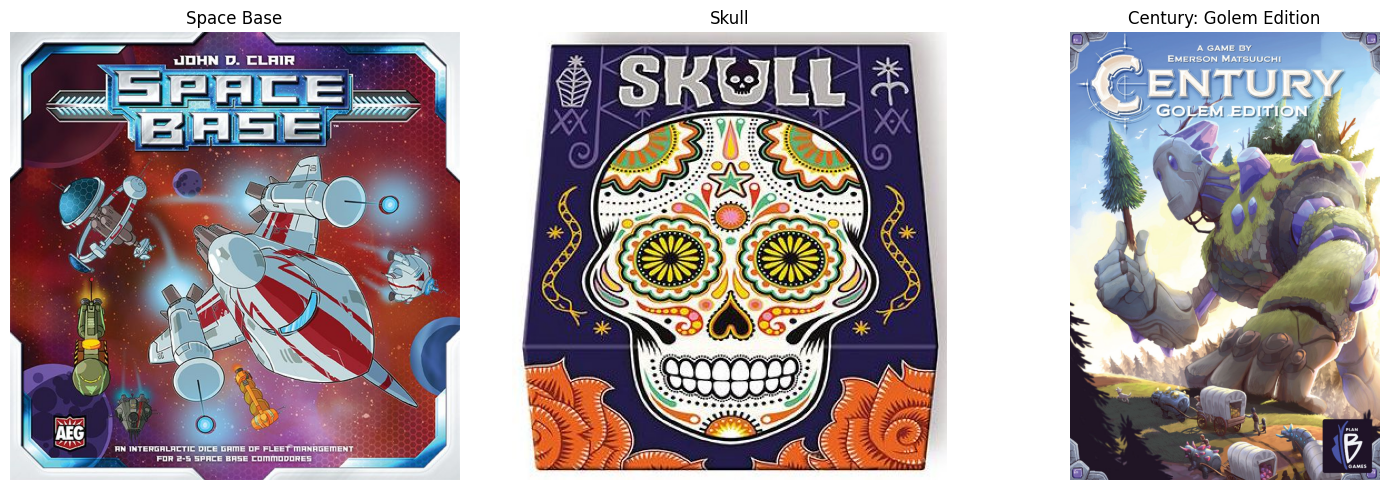

In [11]:
idxs = df_games.BGGId.to_list()

idx1 = int(np.random.choice(idxs))
idx2 = int(np.random.choice(idxs))
idx3 = int(np.random.choice(idxs))
im1 = plt.imread(f'{im_path}/{idx1}.png')
im2 = plt.imread(f'{im_path}/{idx2}.png')
im3 = plt.imread(f'{im_path}/{idx3}.png')

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(im1)
ax[0].set_title(df_games.loc[df_games.BGGId==idx1, 'Name'].values[0])
ax[0].axis('off')
ax[1].imshow(im2)
ax[1].set_title(df_games.loc[df_games.BGGId==idx2, 'Name'].values[0])
ax[1].axis('off')
ax[2].imshow(im3)
ax[2].set_title(df_games.loc[df_games.BGGId==idx3, 'Name'].values[0])
ax[2].axis('off')
plt.tight_layout()
plt.show()



In [12]:
images = [Image.open(f'{im_path}/{idx}.png').convert("RGB") for idx in df_games.BGGId]

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

inputs = processor(images=images, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state[:, :, 0].detach().numpy()


/Users/mglambert/Documents/PhD/Courses/RecSys/RecSysProject/.venv/lib/python3.9/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [13]:
last_hidden_states = PCA(n_components=15).fit_transform(last_hidden_states)

In [14]:
last_hidden_states.shape

(275, 15)

In [15]:
df_games['Image_embedding'] = [emb.tolist() for emb in last_hidden_states]

In [16]:
df_games.head()

,BGGId,Name,Description,YearPublished,GameWeight,AvgRating,BayesAvgRating,StdDev,MinPlayers,MaxPlayers,...,Cat:Strategy,Cat:War,Cat:Family,Cat:CGS,Cat:Abstract,Cat:Party,Cat:Childrens,mask,Description_embedding,Image_embedding
0,88,Torres,torre abstract game resource management tactic...,1999,2.8656,7.10972,6.82406,1.27896,2,4,...,1,0,0,0,1,0,0,True,"[-2.683112726255317, -0.42332172554470826, -1....","[1.6416904926300049, 0.06321828812360764, 0.39..."
1,91,Paths of Glory,gmt game websitethey call great war year titan...,1999,3.8421,8.05888,7.33726,1.64059,2,2,...,0,1,0,0,0,0,0,True,"[1.0637854293471487, 0.649491797066982, 0.4205...","[-1.1839122772216797, -0.6947698593139648, 0.3..."
2,150,PitchCar,game entry refer nearly identical game compati...,1995,1.1263,7.26579,6.99936,1.34552,2,8,...,0,0,1,0,0,1,0,True,"[0.820082462099059, -0.0750128060778531, 1.587...","[1.035536527633667, 1.0266635417938232, -0.521..."
3,171,Chess,chess twoplayer abstract strategy board game r...,1475,3.6886,7.15112,6.96557,1.83887,2,2,...,0,0,0,0,1,0,0,True,"[-0.858757313022056, -0.0162148123075708, 0.17...","[0.8292618989944458, -0.3407784700393677, 0.03..."
4,188,Go,appearance player take turn lay stone time sma...,-2200,3.9420,7.63525,7.31794,1.91275,2,2,...,0,0,0,0,1,0,0,True,"[0.09952368867430286, 0.5561095815916068, 0.60...","[4.239888668060303, -0.1471511274576187, 0.231..."


# Save

In [17]:
df_games.to_csv('../data/df_games_train2.csv', index=False)